In [ ]:
import pickle
import pandas as pd
import re

with open('data_pickle_format/labeled_vacancies_final.pickle', 'rb') as f:
    real_df = pickle.load(f)

real_df['company_name'] = real_df['description'].str.extract(
    r'Company\s*name:\s*(.*?)\s*Job\s*requirements:',
    flags=re.IGNORECASE,
    expand=False
).str.strip()

real_df['requirements'] = real_df['description'].str.extract(
    r'Job\s*requirements\s*:\s*(.*?)\s*Company\s*info:',
    flags=re.IGNORECASE | re.DOTALL,
    expand=False
).str.strip()

real_df['info'] = real_df['description'].str.extract(
    r'Company\s*info\s*:\s*(.*?)\s*Compensation\s*benefits:',
    flags=re.IGNORECASE | re.DOTALL,
    expand=False
).str.strip()

real_df['benefits'] = real_df['description'].str.extract(
    r'Compensation\s*benefits*:\s*(.*?)\s*Certifications:',
    flags=re.IGNORECASE | re.DOTALL,
    expand=False
).str.strip()

real_df['certifications'] = real_df['description'].str.extract(
    r'Certifications\s*:\s*(.*?)\s*Remote\s*possible:',
    flags=re.IGNORECASE | re.DOTALL,
    expand=False
).str.strip()

real_df['remote'] = real_df['description'].str.extract(
    r'Remote\s*possible\s*:\s*(True|False)',
    flags=re.IGNORECASE,
    expand=False
).str.strip()

In [47]:
from string import punctuation
import html

def preprocess_text(text):
    text = text.lower()
    text = html.unescape(text)
    text = re.sub(r"https?://\S+", "", text) # remove http links
    text = re.sub(r"<.*?>", " ", text) # remove html tags
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # Remove punctuation
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines
    return text

real_df["description"] = real_df["description"].map(preprocess_text)
real_df["company_name"] = real_df["company_name"].map(preprocess_text)


real_df['company_name'] = real_df['company_name'].str.replace(
    r'\b(b\.?v\.?|n\.?v\.?)\b', '', 
    flags=re.IGNORECASE, 
    regex=True
).str.strip()

real_df['company_name'] = real_df['company_name'].str.lower().str.strip()
real_df['company_name'] = real_df['company_name'].replace({
    'belastingdienst bcao': 'belastingdienst',
    'ministerie van financi n belastingdienst': 'ministerie van financiën',
    'ministerie van financi n': 'ministerie van financiën',
    'ministerie van financi ': 'ministerie van financiën',
    'dienst uitvoering onderwijs duo': 'duo',
    'koninklijke kpn': 'kpn',
    'asml netherlands': 'asml',
    'abn amro group': 'abn amro',
    'yacht inhouse services': 'yacht',
    'yacht group nederland': 'yacht',
    'yacht nl': 'yacht',
    'yacht it': 'yacht',
    'klant van yacht': 'yacht' ,
    'den haag': 'gemeente den haag',
    'uitvoeringsinstituut werknemersverzekeringen': 'uwv'
})

real_df["requirements"] = real_df["requirements"].map(preprocess_text)
real_df["info"] = real_df["info"].map(preprocess_text)
real_df["benefits"] = real_df["benefits"].map(preprocess_text)
real_df["certifications"] = real_df["certifications"].map(preprocess_text)
real_df["remote"] = real_df["remote"].map(preprocess_text)

In [48]:
import spacy

nlpNL = spacy.load("nl_core_news_sm")

def extract_org(text):
    doc = nlpNL(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            return ent.text.lower().strip() 
    return text.lower().strip() 

real_df['canonical_company'] = real_df['company_name'].astype(str).apply(extract_org)

In [49]:
counts_0_4 = real_df.loc[real_df['women_proportion'] == 0].copy()
counts_1_4 = real_df.loc[real_df['women_proportion'] <= 0.25].copy()
counts_2_4 = real_df.loc[(real_df['women_proportion'] > 0.25) & (real_df['women_proportion'] <= 0.5)].copy()
counts_3_4 = real_df.loc[(real_df['women_proportion'] > 0.5) & (real_df['women_proportion'] <= 0.75)].copy()
counts_4_4 = real_df.loc[real_df['women_proportion'] > 0.75].copy()
counts_5_4 = real_df.loc[real_df['women_proportion'] == 1].copy()

In [50]:
from nltk import FreqDist
import numpy as np

lemmas_0 = counts_0_4['canonical_company'].values
freq_dic_0 = FreqDist(lemmas_0)
display(freq_dic_0)

lemmas_1 = counts_1_4['canonical_company'].values
freq_dic_1=FreqDist(lemmas_1)
display(freq_dic_1)

lemmas_2 = counts_2_4['canonical_company'].values
freq_dic_2=FreqDist(lemmas_2)
display(freq_dic_2)

lemmas_3 = counts_3_4['canonical_company'].values
freq_dic_3=FreqDist(lemmas_3)
display(freq_dic_3)

lemmas_4 = counts_4_4['canonical_company'].values
freq_dic_4 = FreqDist(lemmas_4)
display(freq_dic_4)

lemmas_5 = counts_5_4['canonical_company'].values
freq_dic_5 = FreqDist(lemmas_5)
display(freq_dic_5)

FreqDist({'duo': 177, 'belastingdienst': 144, 'uwv': 140, 'ministerie van financiën': 79, 'yacht': 75, 'gemeente den haag': 59, 'kpn': 45, 'rijkswaterstaat': 45, 'ministerie van buitenlandse zaken': 41, 'abn amro': 32, ...})

FreqDist({'duo': 205, 'uwv': 165, 'belastingdienst': 161, 'yacht': 119, 'ministerie van financiën': 95, 'gemeente den haag': 66, 'kpn': 54, 'rijkswaterstaat': 47, 'ministerie van buitenlandse zaken': 46, 'abn amro': 40, ...})

FreqDist({'yacht': 85, 'duo': 77, 'uwv': 55, 'belastingdienst': 36, 'ministerie van financiën': 33, 'gemeente den haag': 22, 'daf trucks': 20, 'abn amro': 20, 'asml': 15, 'ministerie van buitenlandse zaken': 10, ...})

FreqDist({'duo': 19, 'yacht': 13, 'ministerie van financiën': 10, 'uwv': 8, 'belastingdienst': 7, 'daf trucks': 7, 'kpn': 4, 'gemeente den haag': 3, 'leaseplan digital': 2, 'abn amro': 2, ...})

FreqDist({'belastingdienst': 45, 'uwv': 26, 'duo': 21, 'yacht': 14, 'gemeente den haag': 10, 'ministerie van buitenlandse zaken': 9, 'ministerie van financiën': 8, 'abn amro': 7, 'kpn': 6, 'asml': 6, ...})

FreqDist({'belastingdienst': 45, 'uwv': 25, 'duo': 21, 'yacht': 13, 'gemeente den haag': 10, 'ministerie van buitenlandse zaken': 9, 'ministerie van financiën': 8, 'abn amro': 7, 'kpn': 6, 'randstad global it solutions': 5, ...})

<Axes: title={'center': '100 %'}, xlabel='Samples', ylabel='Counts'>

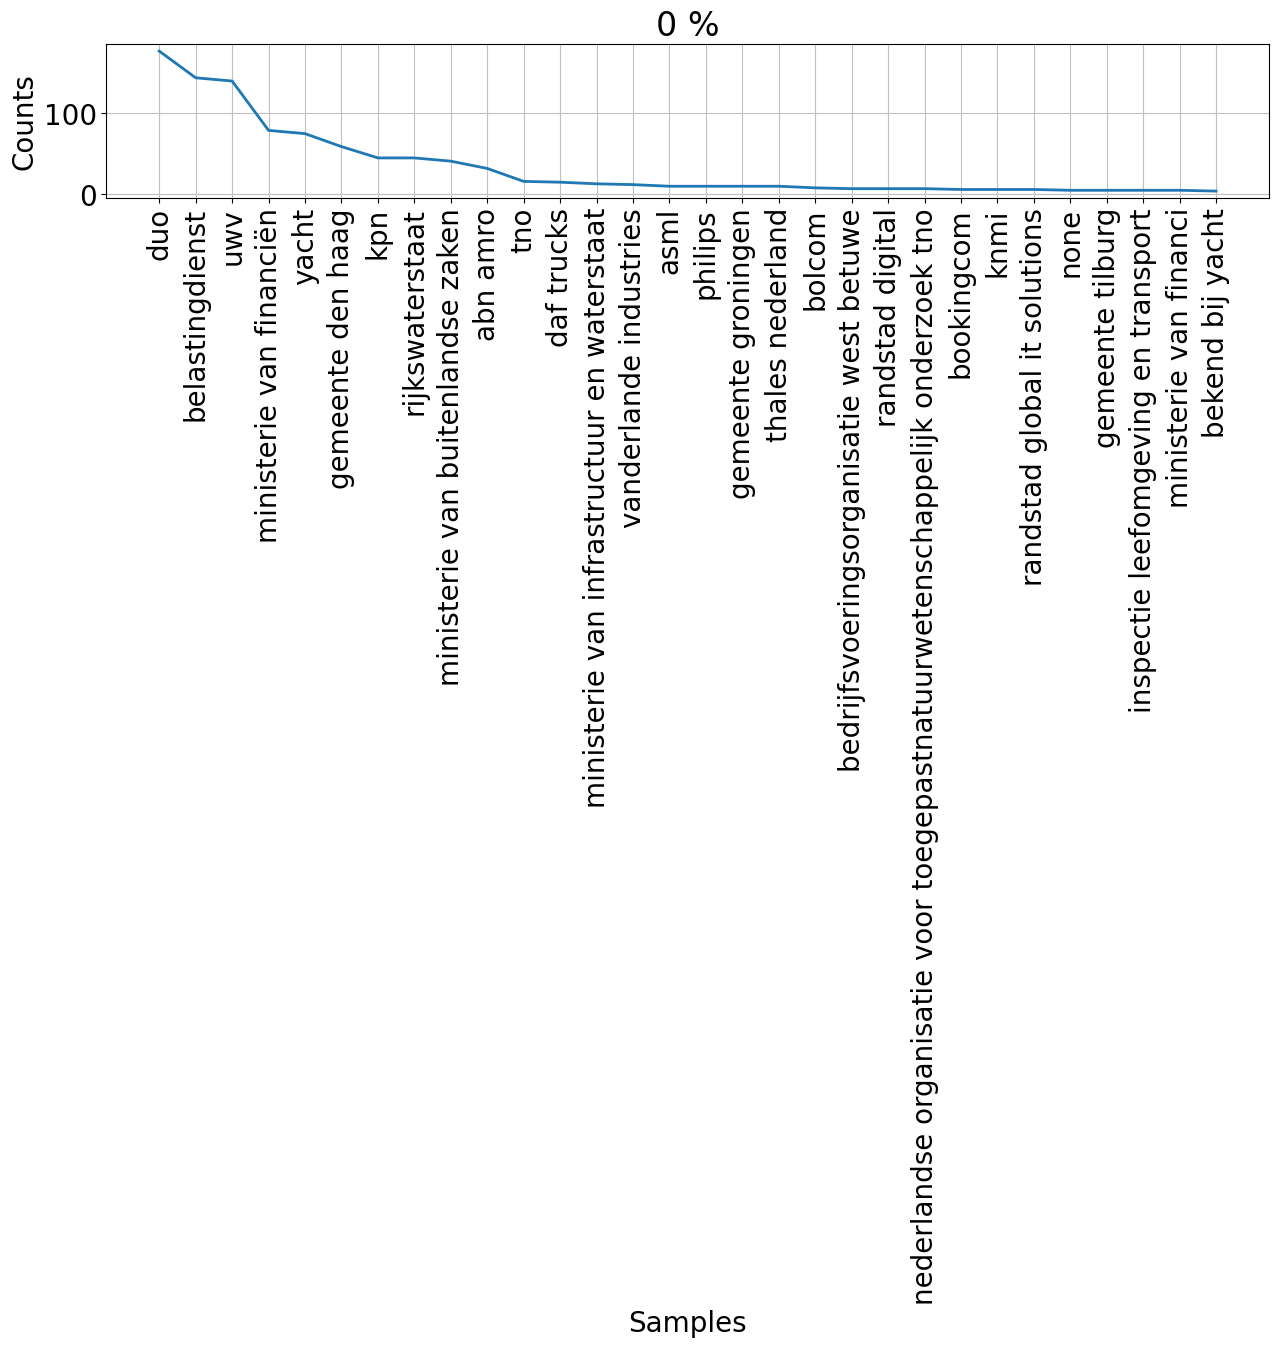

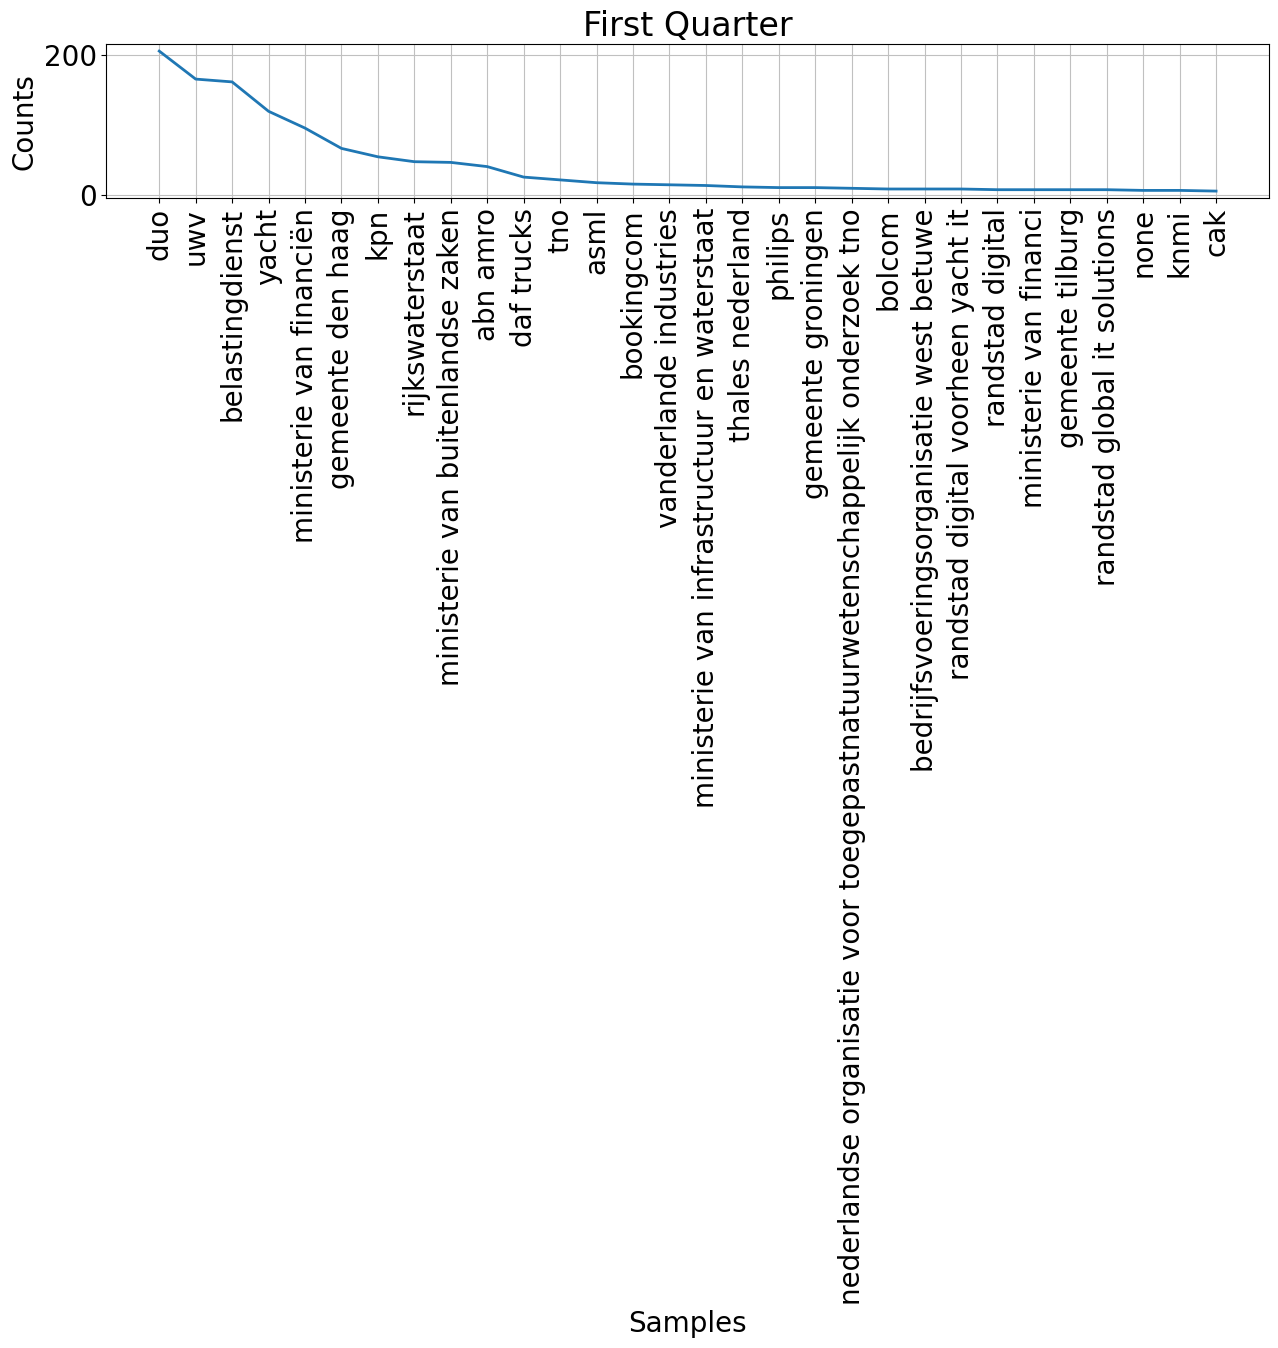

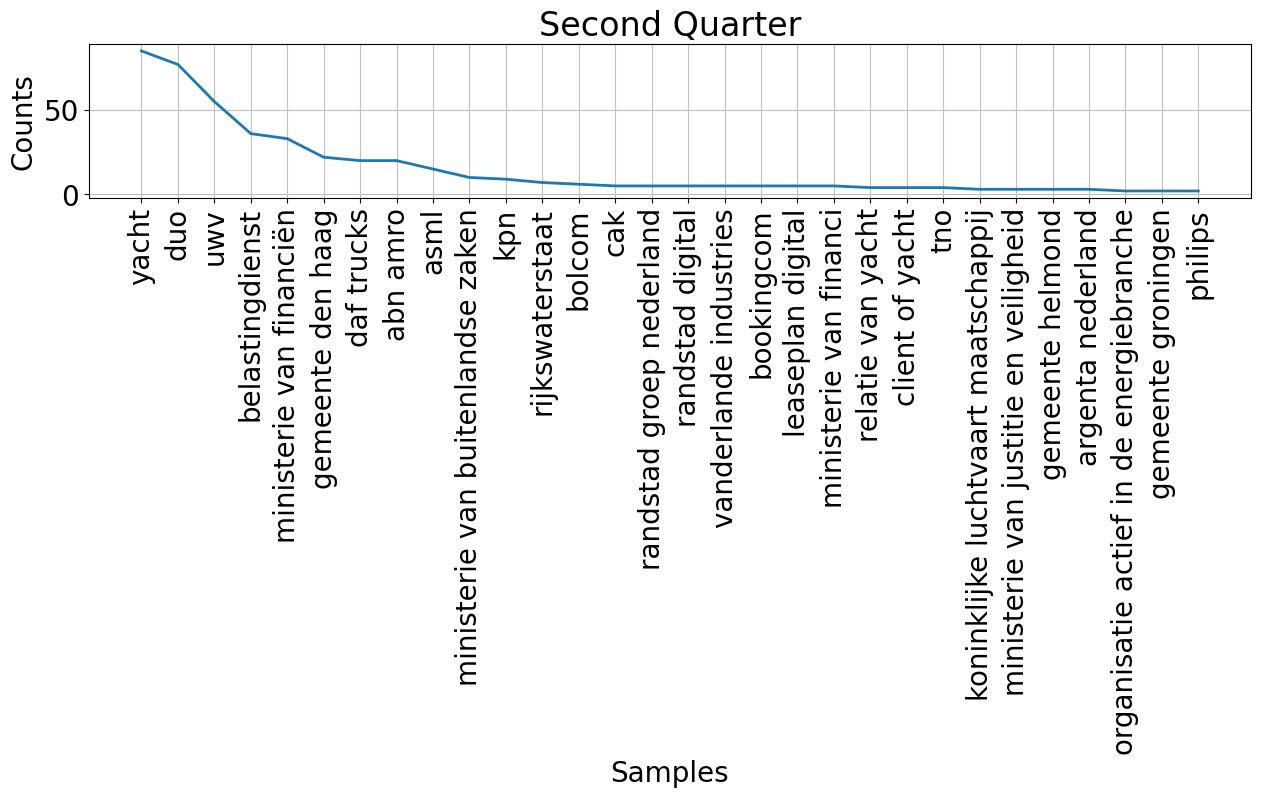

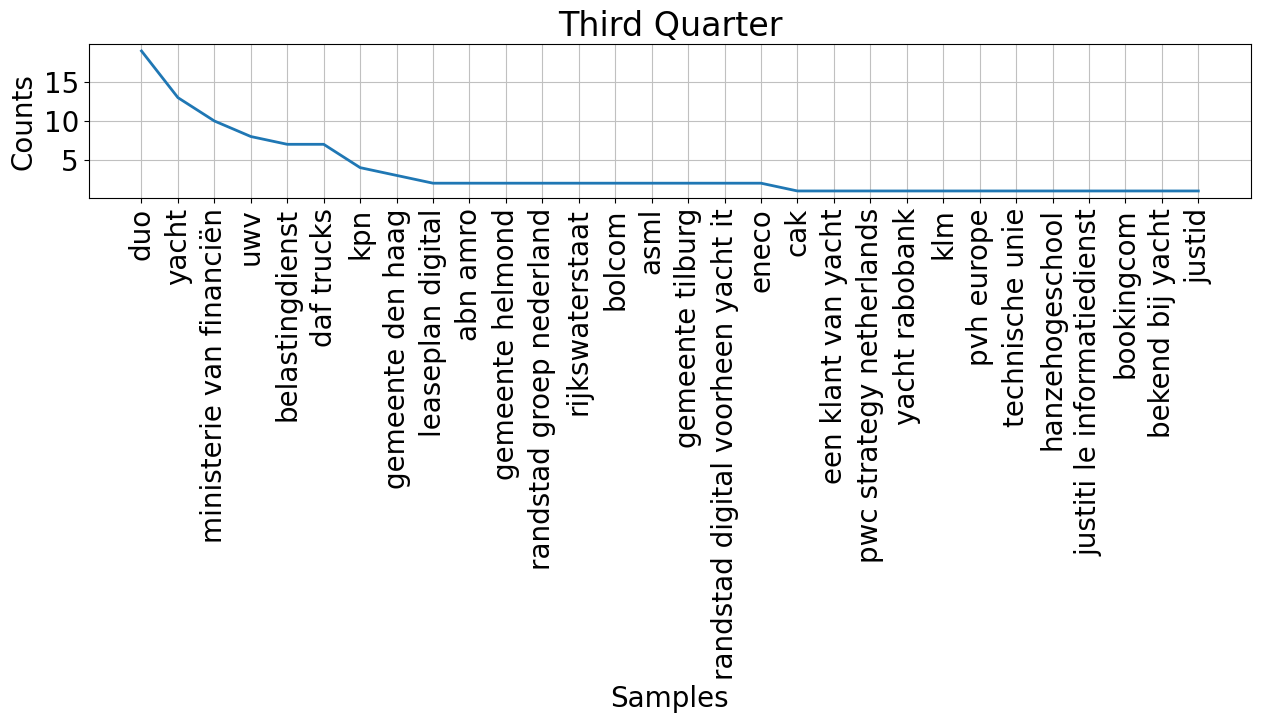

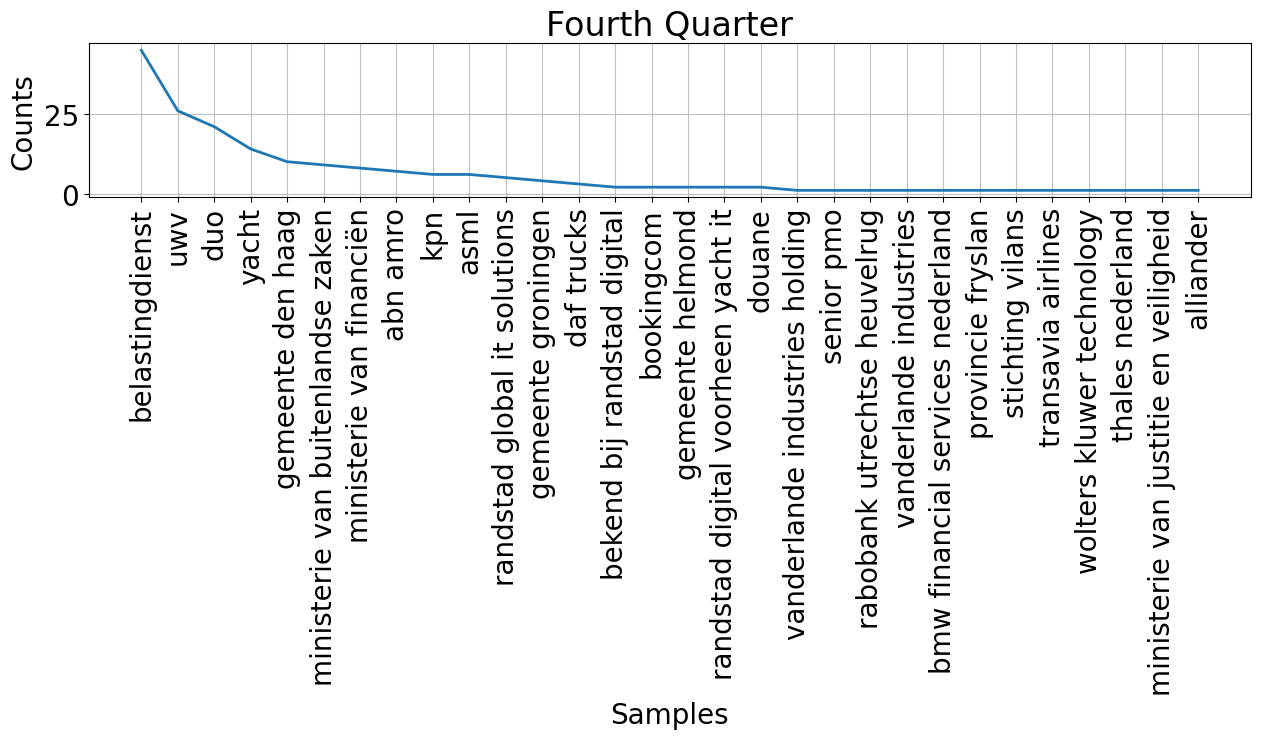

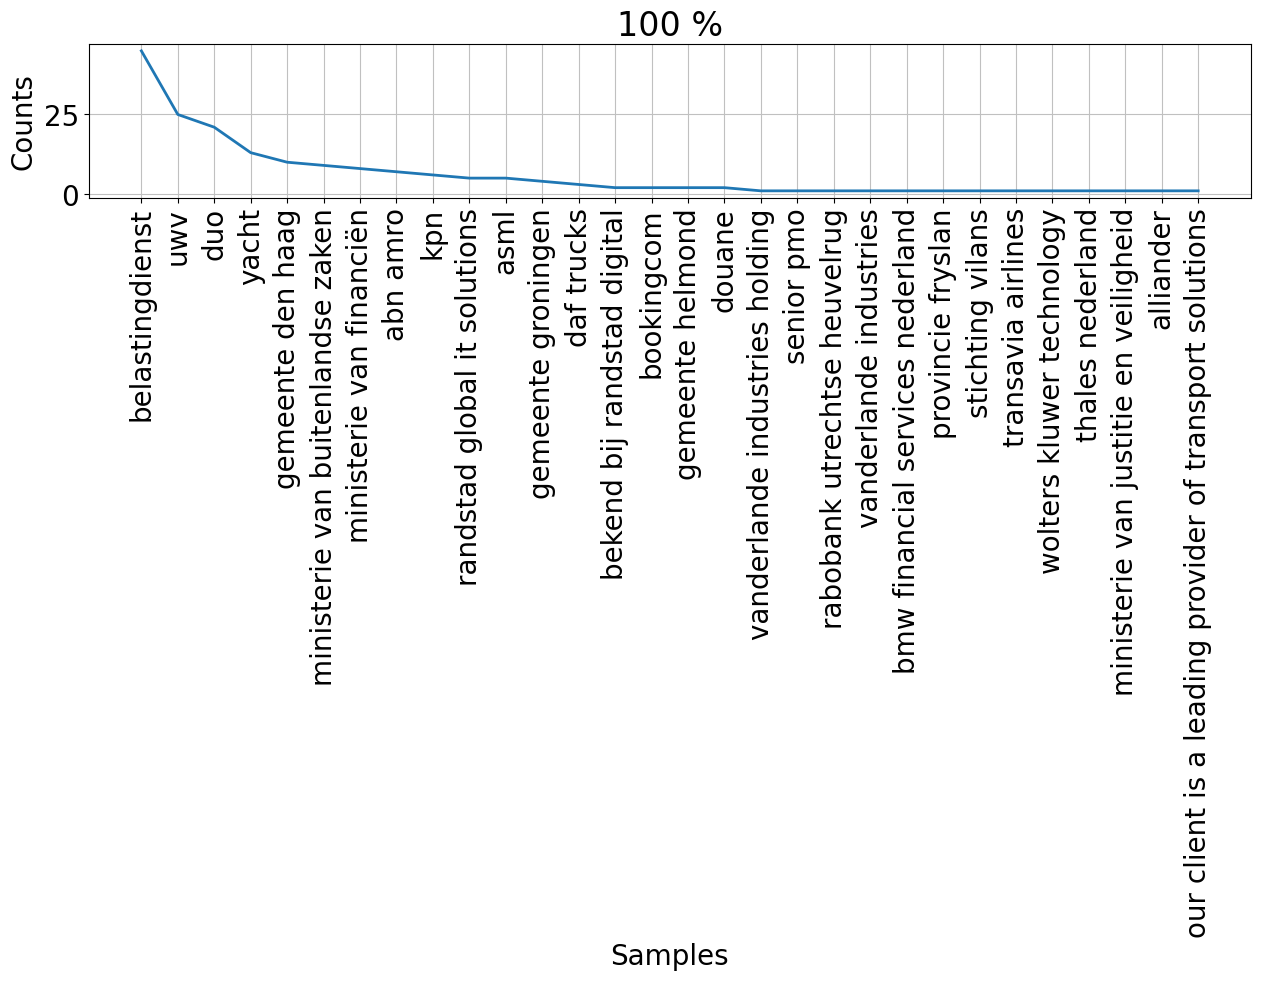

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '20'

plt.figure(figsize=(15,2))
freq_dic_0.plot(30,  title='0 %')
plt.figure(figsize=(15,2))
freq_dic_1.plot(30,  title='First Quarter')
plt.figure(figsize=(15,2))
freq_dic_2.plot(30,  title='Second Quarter')
plt.figure(figsize=(15,2))
freq_dic_3.plot(30,  title='Third Quarter')
plt.figure(figsize=(15,2))
freq_dic_4.plot(30,  title='Fourth Quarter')
plt.figure(figsize=(15,2))
freq_dic_5.plot(30,  title='100 %')

In [52]:
total_0 = len(freq_dic_0)
total_1 = len(freq_dic_1)
total_2 = len(freq_dic_2)
total_3 = len(freq_dic_3)
total_4 = len(freq_dic_4)
total_5 = len(freq_dic_5)

# Convert to frequency proportions
fd0 = {word: count / total_1 for word, count in freq_dic_0.items()}
fd1 = {word: count / total_2 for word, count in freq_dic_1.items()}
fd2 = {word: count / total_3 for word, count in freq_dic_2.items()}
fd3 = {word: count / total_4 for word, count in freq_dic_3.items()}
fd4 = {word: count / total_3 for word, count in freq_dic_4.items()}
fd5 = {word: count / total_4 for word, count in freq_dic_5.items()}

all_words = set(fd0) | set(fd1) | set(fd2) | set(fd3) | set(fd4) | set(fd5)

# Build normalized DataFrame
freq_df = pd.DataFrame({
    'word': list(all_words),
    '0%': [fd0.get(word, 0) for word in all_words],
    'Q1': [fd1.get(word, 0) for word in all_words],
    'Q2': [fd2.get(word, 0) for word in all_words],
    'Q3': [fd3.get(word, 0) for word in all_words],
    'Q4': [fd4.get(word, 0) for word in all_words],
    '100%': [fd5.get(word, 0) for word in all_words]
})

freq_df.set_index('word', inplace=True)
freq_df['total'] = freq_df.sum(axis=1)
freq_df = freq_df.sort_values(by='total', ascending=False)

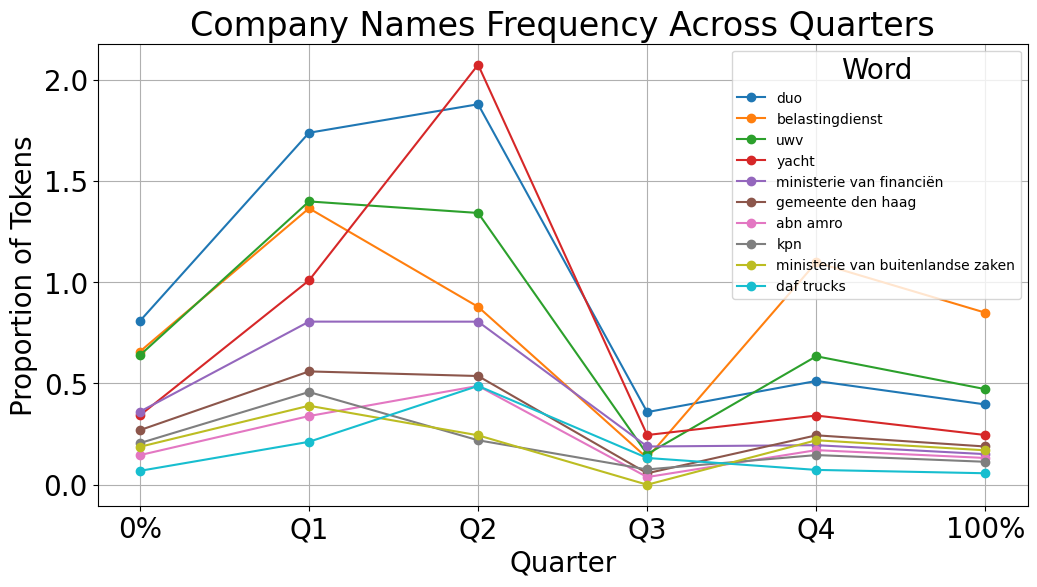

In [53]:
top_companies = freq_df.head(10).index

freq_df.loc[top_companies, ['0%', 'Q1', 'Q2', 'Q3', 'Q4', '100%']].T.plot(
    kind='line', marker='o', figsize=(12, 6)
)
plt.title("Company Names Frequency Across Quarters")
plt.xlabel("Quarter")
plt.ylabel("Proportion of Tokens")
plt.grid(True)
plt.legend(title="Word", prop={'size': 10})
plt.show()